# Phase 5B1: Seasonal Extreme Value Analysis

**Objective**: Understand how extreme values vary by season (Winter vs Summer)

**Why This Matters:**
- Phase 4A gave us **averaged** 100-year Hs over all 10 years
- But: Winter storms ≠ Summer conditions
- Question: Is winter 100-year Hs >> summer 100-year Hs?
- Answer: **Should we avoid winter operations entirely?**

**What We'll Do:**
1. Split data into Winter (DJF) vs Summer (JJA) vs Spring (MAM) vs Autumn (SON)
2. Fit EVA distributions separately for each season
3. Calculate seasonal return periods
4. Compare seasonal extremes
5. Generate seasonal workability recommendations

**Key Questions:**
1. How much higher are winter extremes vs summer?
2. Which months are safest for operations?
3. Does seasonal splitting improve EVA fit?
4. Should contingency days vary by season?

**Data**: 10 years of ERA5 hourly data (2015-2025) for UK Northeast Coast

---

## PART 1: SETUP & DATA LOADING

In [8]:
# Cell 1: Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import gumbel_r, genextreme, weibull_min
from scipy.optimize import minimize
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('Set2')
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 3)

print("✅ Imports complete")
print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")

✅ Imports complete
NumPy: 2.2.6
Pandas: 2.3.3


In [9]:
# Cell 2: Load data and Phase 4A results

print("="*80)
print("LOADING DATA FOR SEASONAL EVA")
print("="*80)

# Load hourly timeseries
df = pd.read_parquet('../data/processed/timeseries/UK_NortheastCoast_2015_2025_complete.parquet')

# Fix index if needed
if 'time' in df.columns:
    df['time'] = pd.to_datetime(df['time'])
    df = df.set_index('time')

print(f"\nTimeseries shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"Variables: {df.columns.tolist()[:10]}")

# Load Phase 4A results for comparison
with open('../data/processed/phase4a/eva_distributions.pkl', 'rb') as f:
    eva_4a = pickle.load(f)

print(f"\nPhase 4A Results (AVERAGED over all 10 years):")
print(f"  Hs: {eva_4a['hs']['monthly_maxima']['distribution']}")
print(f"  Wind: {eva_4a['wind']['monthly_maxima']['distribution']}")
print(f"  Current: {eva_4a['current']['monthly_maxima']['distribution']}")

print("\n" + "="*80)
print("GOAL: Split by season and compare EVA distributions")
print("="*80)

LOADING DATA FOR SEASONAL EVA

Timeseries shape: (15859, 15)
Date range: 2015-01-01 00:00:00 to 2025-11-08 12:00:00
Variables: ['hs', 'tp', 'dir', 'wind_u', 'wind_v', 'wind_speed', 'month', 'month_name', 'current_velocity_mean', 'current_velocity_max']

Phase 4A Results (AVERAGED over all 10 years):
  Hs: Weibull
  Wind: Weibull
  Current: Weibull

GOAL: Split by season and compare EVA distributions


## PART 2: SEASONAL DATA SPLITTING

In [10]:
# Cell 3: Define seasons and extract monthly maxima

# Define meteorological seasons
SEASONS = {
    'Winter': [12, 1, 2],   # DJF (December, January, February)
    'Spring': [3, 4, 5],    # MAM (March, April, May)
    'Summer': [6, 7, 8],    # JJA (June, July, August)
    'Autumn': [9, 10, 11]   # SON (September, October, November)
}

# Add season column
df['month'] = df.index.month
df['season'] = df['month'].apply(lambda m: 
    'Winter' if m in SEASONS['Winter'] else
    'Spring' if m in SEASONS['Spring'] else
    'Summer' if m in SEASONS['Summer'] else
    'Autumn'
)

print("\n" + "="*80)
print("SEASONAL DATA SPLIT")
print("="*80)

# Extract monthly maxima for each season
df['year_month'] = df.index.to_period('M')

seasonal_monthly_maxima = {}

for season, months in SEASONS.items():
    # Filter to season months
    df_season = df[df['month'].isin(months)]
    
    # Extract monthly maxima
    mm_hs = df_season.groupby('year_month')['hs'].max().dropna()
    mm_wind = df_season.groupby('year_month')['wind_speed'].max().dropna()
    mm_current = df_season.groupby('year_month')['current_speed_knots_max'].max().dropna()
    
    seasonal_monthly_maxima[season] = {
        'hs': mm_hs.values,
        'wind': mm_wind.values,
        'current': mm_current.values if len(mm_current) > 0 else np.array([])
    }
    
    print(f"\n{season}:")
    print(f"  Hs monthly maxima: {len(mm_hs)} months")
    print(f"    Mean: {mm_hs.mean():.2f}m, Max: {mm_hs.max():.2f}m, Std: {mm_hs.std():.2f}m")
    print(f"  Wind monthly maxima: {len(mm_wind)} months")
    print(f"    Mean: {mm_wind.mean():.2f}m/s, Max: {mm_wind.max():.2f}m/s, Std: {mm_wind.std():.2f}m/s")
    print(f"  Current monthly maxima: {len(mm_current)} months")
    if len(mm_current) > 0:
        print(f"    Mean: {mm_current.mean():.2f}kt, Max: {mm_current.max():.2f}kt, Std: {mm_current.std():.2f}kt")
    else:
        print(f"    No current data for this season")

print("\n✅ Seasonal monthly maxima extracted")


SEASONAL DATA SPLIT

Winter:
  Hs monthly maxima: 32 months
    Mean: 4.46m, Max: 6.15m, Std: 0.82m
  Wind monthly maxima: 32 months
    Mean: 17.70m/s, Max: 21.82m/s, Std: 1.77m/s
  Current monthly maxima: 11 months
    Mean: 3.38kt, Max: 3.72kt, Std: 0.27kt

Spring:
  Hs monthly maxima: 33 months
    Mean: 3.37m, Max: 6.03m, Std: 0.92m
  Wind monthly maxima: 33 months
    Mean: 14.13m/s, Max: 18.39m/s, Std: 1.92m/s
  Current monthly maxima: 12 months
    Mean: 3.61kt, Max: 3.99kt, Std: 0.29kt

Summer:
  Hs monthly maxima: 33 months
    Mean: 2.42m, Max: 4.18m, Std: 0.56m
  Wind monthly maxima: 33 months
    Mean: 12.70m/s, Max: 16.39m/s, Std: 1.57m/s
  Current monthly maxima: 12 months
    Mean: 3.37kt, Max: 3.72kt, Std: 0.19kt

Autumn:
  Hs monthly maxima: 33 months
    Mean: 4.09m, Max: 7.65m, Std: 1.36m
  Wind monthly maxima: 33 months
    Mean: 15.91m/s, Max: 21.15m/s, Std: 1.99m/s
  Current monthly maxima: 12 months
    Mean: 3.47kt, Max: 3.99kt, Std: 0.32kt

✅ Seasonal monthly

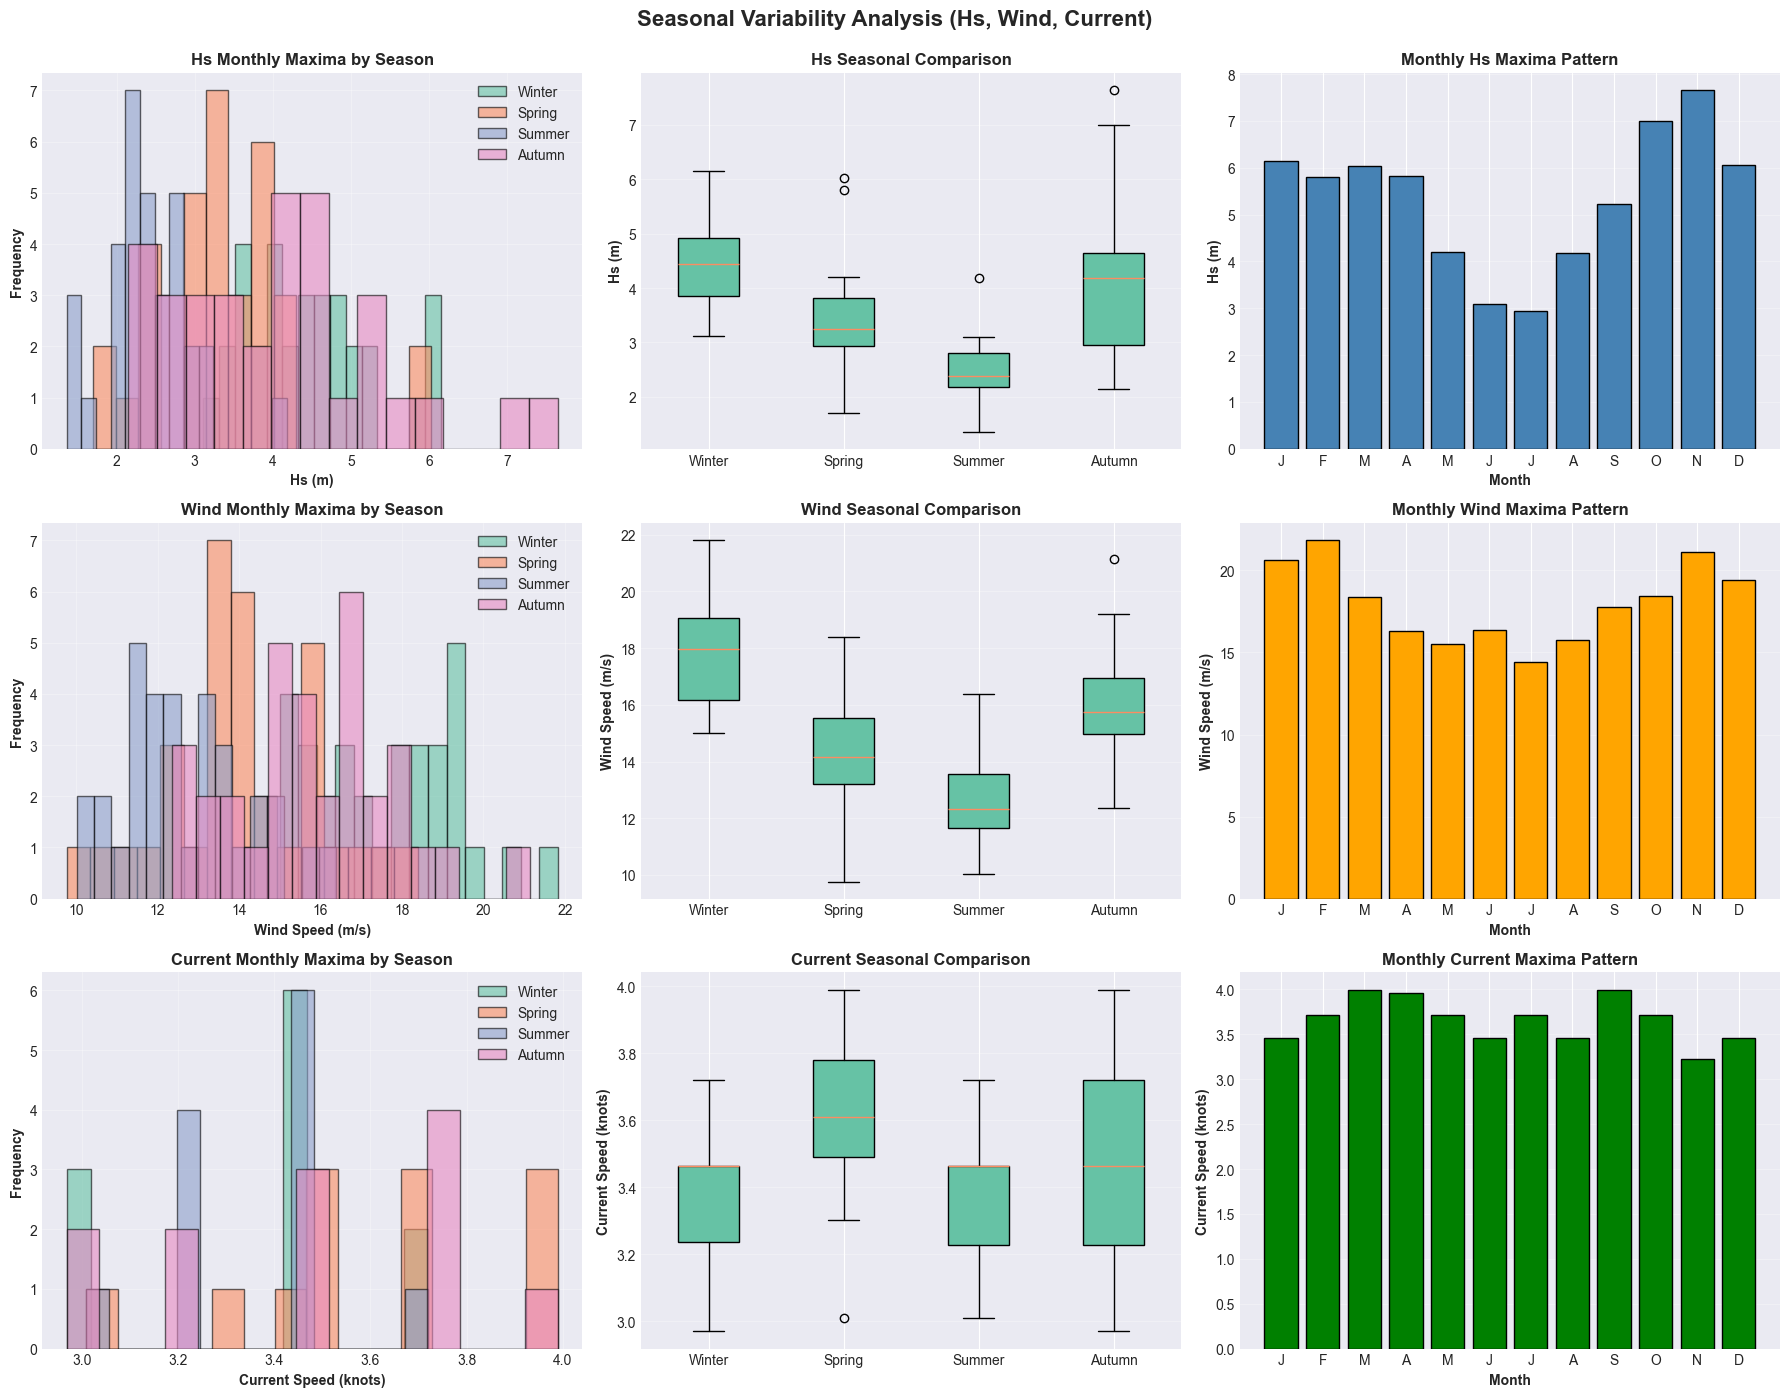


✅ Seasonal differences visualized


In [11]:
# Cell 4: Visualize seasonal differences

fig, axes = plt.subplots(3, 3, figsize=(18, 14))

# Row 1: Hs
# Hs distributions by season
for season in SEASONS.keys():
    axes[0, 0].hist(seasonal_monthly_maxima[season]['hs'], bins=15, alpha=0.6, 
                    label=season, edgecolor='black')
axes[0, 0].set_xlabel('Hs (m)', fontweight='bold')
axes[0, 0].set_ylabel('Frequency', fontweight='bold')
axes[0, 0].set_title('Hs Monthly Maxima by Season', fontweight='bold', fontsize=12)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Hs Boxplot comparison
hs_seasonal = [seasonal_monthly_maxima[s]['hs'] for s in SEASONS.keys()]
axes[0, 1].boxplot(hs_seasonal, labels=list(SEASONS.keys()), patch_artist=True)
axes[0, 1].set_ylabel('Hs (m)', fontweight='bold')
axes[0, 1].set_title('Hs Seasonal Comparison', fontweight='bold', fontsize=12)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Hs Monthly pattern
monthly_hs = df.groupby(df.index.month)['hs'].max()
axes[0, 2].bar(range(1, 13), monthly_hs.values, color='steelblue', edgecolor='black')
axes[0, 2].set_xlabel('Month', fontweight='bold')
axes[0, 2].set_ylabel('Hs (m)', fontweight='bold')
axes[0, 2].set_title('Monthly Hs Maxima Pattern', fontweight='bold', fontsize=12)
axes[0, 2].set_xticks(range(1, 13))
axes[0, 2].set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
axes[0, 2].grid(True, alpha=0.3, axis='y')

# Row 2: Wind
# Wind distributions by season
for season in SEASONS.keys():
    axes[1, 0].hist(seasonal_monthly_maxima[season]['wind'], bins=15, alpha=0.6, 
                    label=season, edgecolor='black')
axes[1, 0].set_xlabel('Wind Speed (m/s)', fontweight='bold')
axes[1, 0].set_ylabel('Frequency', fontweight='bold')
axes[1, 0].set_title('Wind Monthly Maxima by Season', fontweight='bold', fontsize=12)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Wind Boxplot comparison
wind_seasonal = [seasonal_monthly_maxima[s]['wind'] for s in SEASONS.keys()]
axes[1, 1].boxplot(wind_seasonal, labels=list(SEASONS.keys()), patch_artist=True)
axes[1, 1].set_ylabel('Wind Speed (m/s)', fontweight='bold')
axes[1, 1].set_title('Wind Seasonal Comparison', fontweight='bold', fontsize=12)
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Wind Monthly pattern
monthly_wind = df.groupby(df.index.month)['wind_speed'].max()
axes[1, 2].bar(range(1, 13), monthly_wind.values, color='orange', edgecolor='black')
axes[1, 2].set_xlabel('Month', fontweight='bold')
axes[1, 2].set_ylabel('Wind Speed (m/s)', fontweight='bold')
axes[1, 2].set_title('Monthly Wind Maxima Pattern', fontweight='bold', fontsize=12)
axes[1, 2].set_xticks(range(1, 13))
axes[1, 2].set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
axes[1, 2].grid(True, alpha=0.3, axis='y')

# Row 3: Current
# Current distributions by season
for season in SEASONS.keys():
    curr_data = seasonal_monthly_maxima[season]['current']
    if len(curr_data) > 0:
        axes[2, 0].hist(curr_data, bins=15, alpha=0.6, 
                        label=season, edgecolor='black')
axes[2, 0].set_xlabel('Current Speed (knots)', fontweight='bold')
axes[2, 0].set_ylabel('Frequency', fontweight='bold')
axes[2, 0].set_title('Current Monthly Maxima by Season', fontweight='bold', fontsize=12)
axes[2, 0].legend()
axes[2, 0].grid(True, alpha=0.3)

# Current Boxplot comparison (only for seasons with data)
current_seasonal = [seasonal_monthly_maxima[s]['current'] for s in SEASONS.keys() 
                    if len(seasonal_monthly_maxima[s]['current']) > 0]
current_labels = [s for s in SEASONS.keys() if len(seasonal_monthly_maxima[s]['current']) > 0]
if current_seasonal:
    axes[2, 1].boxplot(current_seasonal, labels=current_labels, patch_artist=True)
    axes[2, 1].set_ylabel('Current Speed (knots)', fontweight='bold')
    axes[2, 1].set_title('Current Seasonal Comparison', fontweight='bold', fontsize=12)
    axes[2, 1].grid(True, alpha=0.3, axis='y')
else:
    axes[2, 1].text(0.5, 0.5, 'No Current Data', ha='center', va='center', fontsize=14)
    axes[2, 1].set_title('Current Seasonal Comparison', fontweight='bold', fontsize=12)

# Current Monthly pattern
if 'current_speed_knots_max' in df.columns:
    monthly_current = df.groupby(df.index.month)['current_speed_knots_max'].max()
    axes[2, 2].bar(range(1, 13), monthly_current.values, color='green', edgecolor='black')
    axes[2, 2].set_xlabel('Month', fontweight='bold')
    axes[2, 2].set_ylabel('Current Speed (knots)', fontweight='bold')
    axes[2, 2].set_title('Monthly Current Maxima Pattern', fontweight='bold', fontsize=12)
    axes[2, 2].set_xticks(range(1, 13))
    axes[2, 2].set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
    axes[2, 2].grid(True, alpha=0.3, axis='y')
else:
    axes[2, 2].text(0.5, 0.5, 'No Current Data', ha='center', va='center', fontsize=14)
    axes[2, 2].set_title('Monthly Current Maxima Pattern', fontweight='bold', fontsize=12)

plt.suptitle('Seasonal Variability Analysis (Hs, Wind, Current)', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n✅ Seasonal differences visualized")

## PART 3: SEASONAL EVA FITTING

In [12]:
# Cell 5: Fit EVA distributions for each season

def fit_eva_distributions(data, var_name):
    """
    Fit Gumbel, GEV, and Weibull to data and return best fit.
    """
    results = {}
    
    # Gumbel
    try:
        params_gumbel = gumbel_r.fit(data)
        loglik_gumbel = np.sum(gumbel_r.logpdf(data, *params_gumbel))
        aic_gumbel = 2 * len(params_gumbel) - 2 * loglik_gumbel
        results['Gumbel'] = {'params': params_gumbel, 'aic': aic_gumbel, 'loglik': loglik_gumbel}
    except:
        results['Gumbel'] = {'params': None, 'aic': np.inf, 'loglik': -np.inf}
    
    # GEV
    try:
        params_gev = genextreme.fit(data)
        loglik_gev = np.sum(genextreme.logpdf(data, *params_gev))
        aic_gev = 2 * len(params_gev) - 2 * loglik_gev
        results['GEV'] = {'params': params_gev, 'aic': aic_gev, 'loglik': loglik_gev}
    except:
        results['GEV'] = {'params': None, 'aic': np.inf, 'loglik': -np.inf}
    
    # Weibull
    try:
        params_weibull = weibull_min.fit(data, floc=0)
        loglik_weibull = np.sum(weibull_min.logpdf(data, *params_weibull))
        aic_weibull = 2 * len(params_weibull) - 2 * loglik_weibull
        results['Weibull'] = {'params': params_weibull, 'aic': aic_weibull, 'loglik': loglik_weibull}
    except:
        results['Weibull'] = {'params': None, 'aic': np.inf, 'loglik': -np.inf}
    
    # Find best fit
    best_dist = min(results.items(), key=lambda x: x[1]['aic'])
    
    return results, best_dist[0], best_dist[1]

print("\n" + "="*80)
print("SEASONAL EVA FITTING")
print("="*80)

seasonal_eva_results = {}

for var in ['hs', 'wind', 'current']:
    print(f"\n{'='*80}")
    print(f"Variable: {var.upper()}")
    print(f"{'='*80}")
    
    seasonal_eva_results[var] = {}
    
    for season in SEASONS.keys():
        data = seasonal_monthly_maxima[season][var]
        
        if len(data) < 10:
            print(f"\n{season}: Insufficient data ({len(data)} months) - skipping")
            continue
        
        print(f"\n{season} ({len(data)} months):")
        
        all_results, best_dist, best_fit = fit_eva_distributions(data, var)
        
        # Print all fits
        for dist, res in all_results.items():
            if res['params'] is not None:
                print(f"  {dist:10s}: AIC={res['aic']:8.2f}, LogLik={res['loglik']:8.2f}")
        
        print(f"  ✅ Best: {best_dist} (AIC={best_fit['aic']:.2f})")
        
        seasonal_eva_results[var][season] = {
            'all_fits': all_results,
            'best_distribution': best_dist,
            'best_params': best_fit['params'],
            'best_aic': best_fit['aic'],
            'data': data
        }

print("\n" + "="*80)
print("✅ Seasonal EVA fitting complete")
print("="*80)


SEASONAL EVA FITTING

Variable: HS

Winter (32 months):
  Gumbel    : AIC=   79.62, LogLik=  -37.81
  GEV       : AIC=   81.23, LogLik=  -37.62
  Weibull   : AIC=   85.84, LogLik=  -39.92
  ✅ Best: Gumbel (AIC=79.62)

Spring (33 months):
  Gumbel    : AIC=   88.89, LogLik=  -42.44
  GEV       : AIC=   90.26, LogLik=  -42.13
  Weibull   : AIC=   95.51, LogLik=  -44.76
  ✅ Best: Gumbel (AIC=88.89)

Summer (33 months):
  Gumbel    : AIC=   59.97, LogLik=  -27.98
  GEV       : AIC=   59.69, LogLik=  -26.84
  Weibull   : AIC=   62.72, LogLik=  -28.36
  ✅ Best: GEV (AIC=59.69)

Autumn (33 months):
  Gumbel    : AIC=  113.89, LogLik=  -54.95
  GEV       : AIC=  115.75, LogLik=  -54.88
  Weibull   : AIC=  118.49, LogLik=  -56.25
  ✅ Best: Gumbel (AIC=113.89)

Variable: WIND

Winter (32 months):
  Gumbel    : AIC=  130.92, LogLik=  -63.46
  GEV       : AIC=  131.51, LogLik=  -62.75
  Weibull   : AIC=  135.27, LogLik=  -64.63
  ✅ Best: Gumbel (AIC=130.92)

Spring (33 months):
  Gumbel    : AIC=

## PART 4: SEASONAL RETURN PERIODS

In [13]:
# Cell 6: Calculate seasonal return periods

def calculate_return_level(distribution, params, return_period_years):
    """
    Calculate return level for given return period.
    
    For monthly maxima:
    N observations per year = 12 months
    Exceedance probability = 1 / (return_period_years * 12)
    Return level = quantile at (1 - exceedance_probability)
    """
    n_per_year = 12  # monthly maxima
    exc_prob = 1.0 / (return_period_years * n_per_year)
    quantile = 1 - exc_prob
    
    if distribution == 'Gumbel':
        return gumbel_r.ppf(quantile, *params)
    elif distribution == 'GEV':
        return genextreme.ppf(quantile, *params)
    elif distribution == 'Weibull':
        return weibull_min.ppf(quantile, *params)
    else:
        return np.nan

return_periods = [1, 5, 10, 25, 50, 100]

print("\n" + "="*80)
print("SEASONAL RETURN PERIODS")
print("="*80)

seasonal_return_levels = {}

for var in ['hs', 'wind', 'current']:
    print(f"\n{'='*80}")
    print(f"{var.upper()} RETURN LEVELS BY SEASON")
    print(f"{'='*80}")
    
    seasonal_return_levels[var] = {}
    
    # Header
    header = f"{'Season':<12}" + "".join([f"{rp}-year" + " "*5 for rp in return_periods])
    print(f"\n{header}")
    print("-" * 80)
    
    for season in SEASONS.keys():
        if season not in seasonal_eva_results[var]:
            continue
        
        result = seasonal_eva_results[var][season]
        dist = result['best_distribution']
        params = result['best_params']
        
        return_levels = {}
        row = f"{season:<12}"
        
        for rp in return_periods:
            rl = calculate_return_level(dist, params, rp)
            return_levels[rp] = rl
            row += f"{rl:8.2f}  "
        
        print(row)
        seasonal_return_levels[var][season] = return_levels
    
    # Phase 4A comparison (averaged)
    print("\n" + "-" * 80)
    print("PHASE 4A (AVERAGED over all seasons):")
    phase4a_dist = eva_4a[var]['monthly_maxima']['distribution']
    phase4a_params = eva_4a[var]['monthly_maxima']['params']
    
    row = f"{'Phase 4A':<12}"
    for rp in return_periods:
        rl = calculate_return_level(phase4a_dist, phase4a_params, rp)
        row += f"{rl:8.2f}  "
    print(row)

print("\n" + "="*80)
print("✅ Seasonal return periods calculated")
print("="*80)


SEASONAL RETURN PERIODS

HS RETURN LEVELS BY SEASON

Season      1-year     5-year     10-year     25-year     50-year     100-year     
--------------------------------------------------------------------------------
Winter          5.74      6.86      7.33      7.96      8.43      8.90  
Spring          4.83      6.10      6.64      7.35      7.89      8.42  
Summer          3.25      3.77      3.95      4.17      4.31      4.44  
Autumn          6.14      7.94      8.71      9.72     10.48     11.24  

--------------------------------------------------------------------------------
PHASE 4A (AVERAGED over all seasons):
Phase 4A        5.40      6.58      7.01      7.53      7.90      8.25  

WIND RETURN LEVELS BY SEASON

Season      1-year     5-year     10-year     25-year     50-year     100-year     
--------------------------------------------------------------------------------
Winter         20.58     23.10     24.16     25.57     26.63     27.69  
Spring         16.80     18

## PART 5: SAVE RESULTS

In [14]:
# Cell 7: Save seasonal EVA results

os.makedirs('../data/processed/phase5b1', exist_ok=True)

results = {
    'seasonal_monthly_maxima': seasonal_monthly_maxima,
    'seasonal_eva_results': seasonal_eva_results,
    'seasonal_return_levels': seasonal_return_levels,
    'seasons': SEASONS
}

with open('../data/processed/phase5b1/seasonal_eva_results.pkl', 'wb') as f:
    pickle.dump(results, f)

print("✅ Seasonal EVA results saved to: data/processed/phase5b1/seasonal_eva_results.pkl")

✅ Seasonal EVA results saved to: data/processed/phase5b1/seasonal_eva_results.pkl
